## <u>*Regression Modelling for Frequency as a Target Feature*</u>

In [ ]:
%run C:\Users\Omar\Desktop\Omar_Files\Python_Analysis\Auto_Insurance\Notebooks\Data_Analysis\3_EDA.ipynb

In [2]:
df5=df.copy()
df5.drop(["clm"],axis=1,inplace=True)

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor,XGBRFRegressor
import warnings
from catboost import CatBoostRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from hyperopt import fmin,tpe,STATUS_OK,Trials,hp


---

### *A.*<br> <u>*Models Preparation :*</u>

#### *A.1. <br> <u>Regression Models to use :*</u>

In [9]:
models = {
                "Random Forest": RandomForestRegressor(random_state=41),
                "Decision Tree": DecisionTreeRegressor(random_state=41),
                "XGBRFRegressor":XGBRFRegressor(random_state=41),
                "CatBoosting Regressor": CatBoostRegressor(verbose=False,random_state=41),
                "AdaBoost Regressor": AdaBoostRegressor(random_state=41),
            }

#### *A.2. <br> <u>Regression Models spaces preperartion to use in hyperopt :*</u>

In [10]:
space_rf = {    
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    #'criterion': hp.choice('criterion', ['poisson', 'squared_error','friedman_mse','absolute_error']),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    #'max_features': hp.choice('max_features',range(1, 4)),
    'bootstrap': hp.choice('bootstrap', [True, False])
    }


space_dt = {
    #'criterion': hp.choice('criterion', ['poisson', 'squared_error','friedman_mse','absolute_error']),
    #'splitter': hp.choice('splitter', ['best', 'random']),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    #'max_features': hp.choice('max_features',range(1, 4)),
    }

space_XGBRFRegressor = {
  'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 1),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
}

space_catboost = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'depth': hp.choice('depth', range(1, 12)),
    'iterations': hp.choice('iterations', range(50, 200)),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0.1, 10),
    'border_count': hp.choice('border_count', [32, 64, 128, 256]),
    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),
    'random_strength': hp.uniform('random_strength', 0, 1),
}
   

space_adaboost = {
    'n_estimators': hp.choice('n_estimators', range(50, 200)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0)
}


---

### *B. <br> <u>Data preparation:*</u>

#### *B.1. <br> <u>LabelEncoding for categorical features :*</u>

In [11]:
LabelEncoder_cat = LabelEncoder()
for col in df5:
    if col in ["numclaims","veh_body","veh_age","gender","area","agecat"]:
        df5[col]=LabelEncoder_cat.fit_transform(df5[col])

#### *B.2. <br> <u>Define x & y features :*</u>

In [12]:
x=df5.drop("frequincy",axis=1)
y=df5["frequincy"]

#### *B.3. <br> <u>data splitting (training & testing) :*</u>

In [13]:
xtrain,xtest, ytrain, ytest = train_test_split(x, y, train_size=0.7, test_size=0.3,random_state=41)

---

### *C. <br> <u>Modelling:*</u>

* *Note : Data scalling is not required as we are applying Tree -based models*

#### *C.1 <br> <u>* *XGBRFRegression:*</u>

In [14]:
def model_XGBRFRegressor(space_XGBRFRegressor):
    mae_scores =[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("XGBRFRegressor",XGBRFRegressor(
                n_estimators=int(space_XGBRFRegressor['n_estimators']),
                learning_rate=float(space_XGBRFRegressor["learning_rate"]), 
                max_depth=int(space_XGBRFRegressor['max_depth']),
                min_child_weight=int(space_XGBRFRegressor['min_child_weight']),
                subsample=float(space_XGBRFRegressor['subsample']),
                gamma=float(space_XGBRFRegressor['gamma']),
                colsample_bynode=float(space_XGBRFRegressor['colsample_bynode']),
                reg_alpha=float(space_XGBRFRegressor['reg_alpha']),
                reg_lambda=float(space_XGBRFRegressor['reg_lambda'])))                   
                                    

                                    ])
                                  
    model_opt.fit(xtrain,ytrain)
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            }

In [15]:
def model_XGBRFRegressor_best(best_model_XGBRFRegressor):
    y_XGBRFRegressor_best=[]
    model_opt_best = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("XGBRFRegressor",XGBRFRegressor(
                n_estimators=int(best_model_XGBRFRegressor['n_estimators']),
                learning_rate=float(best_model_XGBRFRegressor["learning_rate"]), 
                max_depth=int(best_model_XGBRFRegressor['max_depth']),
                min_child_weight=int(best_model_XGBRFRegressor['min_child_weight']),
                subsample=float(best_model_XGBRFRegressor['subsample']),
                gamma=float(best_model_XGBRFRegressor['gamma']),
                colsample_bynode=float(best_model_XGBRFRegressor['colsample_bynode']),
                reg_alpha=float(best_model_XGBRFRegressor['reg_alpha']),
                reg_lambda=float(best_model_XGBRFRegressor['reg_lambda']))) 
                 
                  ])
    
    model_opt_best.fit(xtrain,ytrain)    
    y_pred = model_opt_best.predict(xtest)
    y_XGBRFRegressor_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_XGBRFRegressor_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_XGBRFRegressor_best is %.2f" %score) 

In [16]:
best_model_XGBRFRegressor = fmin(fn=model_XGBRFRegressor, space=space_XGBRFRegressor, algo=tpe.suggest, max_evals=10)
model_XGBRFRegressor_best(best_model_XGBRFRegressor)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [00:07<00:00,  1.28trial/s, best loss: 0.05729530397451784]
model_XGBRFRegressor_best MAE: 0.1186106713763616
 Accuracy of the model_XGBRFRegressor_best is 88.75


---

#### *C.2 <br> <u>* *RandomForestRegressor:*</u>

In [65]:
def model_rf(space_rf):
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("RandomForestRegressor",RandomForestRegressor(
                                    n_estimators=int(space_rf['n_estimators']),
                                    max_depth=int(space_rf["max_depth"]),                                                     
                                    #criterion=str(space_rf['criterion']),
                                    min_samples_split=float(space_rf['min_samples_split']),
                                    min_samples_leaf=float(space_rf['min_samples_leaf']),
                                    #max_features=int(space_rf['max_features']),
                                    bootstrap=int(space_rf['bootstrap'])
                                    ))

                                    ])
                                                 
                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            }  

In [66]:
def model_rf_best(best_model_rf):
    y_RandomForestRegressor_best=[]
    model_opt_best = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("RandomForestRegressor",RandomForestRegressor(
                                    n_estimators=int(best_model_rf['n_estimators']),
                                    max_depth=int(best_model_rf["max_depth"]),                                                     
                                    #criterion=str(best_model_rf['criterion']),
                                    min_samples_split=float(best_model_rf['min_samples_split']),
                                    min_samples_leaf=float(best_model_rf['min_samples_leaf']),
                                    #max_features=int(best_model_rf['max_features']),
                                    bootstrap=int(best_model_rf['bootstrap'])
                                    ))

                                    ]).fit(xtrain,ytrain)  
    
    y_pred = model_opt_best.predict(xtest)
    y_RandomForestRegressor_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('model_rf_best MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_rf_best is %.2f" %score) 

In [67]:
best_model_rf = fmin(fn=model_rf, space=space_rf, algo=tpe.suggest, max_evals=10)
model_rf_best(best_model_rf)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [00:08<00:00,  1.15trial/s, best loss: 0.39331892932520185]
model_rf_best MAE: 0.40162574136776885
 Accuracy of the model_rf_best is 0.08


---

#### *C.3 <br> <u>* *DecisionTreeRegressor:*</u>

In [68]:
def model_DT(space_dt):
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("DecisionTreeRegressor",DecisionTreeRegressor(
                                    #criterion=str(space_dt['criterion']),
                                    #splitter=str(space_dt["splitter"]),                                           
                                    max_depth=int(space_dt['max_depth']),
                                    min_samples_split=float(space_dt['min_samples_split']),
                                    min_samples_leaf=float(space_dt['min_samples_leaf']),
                                    #max_features=int(space_dt['max_features'])
                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            } 


In [69]:
def model_DT_best(best_model_DT):
    y_DT_best=[]
    model_opt_best = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("DecisionTreeRegressor",DecisionTreeRegressor(
                                    #criterion=str(best_model_DT['criterion']),
                                    #splitter=str(best_model_DT["splitter"]),                                           
                                    max_depth=int(best_model_DT['max_depth']),
                                    min_samples_split=float(best_model_DT['min_samples_split']),
                                    min_samples_leaf=float(best_model_DT['min_samples_leaf'])
                                    #max_features=int(best_model_DT['max_features'])
                                    ))])


    model_opt_best.fit(xtrain,ytrain)    
    y_pred = model_opt_best.predict(xtest)
    y_DT_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('DecisionTreeRegressor MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the model_DecisionTreeRegressor_best is %.2f" %score)                                
    

In [70]:
best_model_DT = fmin(fn=model_DT, space=space_dt, algo=tpe.suggest, max_evals=10)
model_DT_best(best_model_DT)

100%|██████████| 10/10 [00:00<00:00, 33.44trial/s, best loss: 0.40035929716301116]
DecisionTreeRegressor MAE: 0.4003592971630117
 Accuracy of the model_DecisionTreeRegressor_best is 0.07


---

#### *C.4 <br> <u>* *CatBoostRegressor:*</u>

In [72]:
def model_catboost(space_catboost):
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostRegressor(
                                    learning_rate=float(space_catboost['learning_rate']),
                                    depth=int(space_catboost["depth"]),                                                       
                                    iterations=int(space_catboost['iterations']),
                                    l2_leaf_reg=float(space_catboost['l2_leaf_reg']),
                                    border_count=int(space_catboost['border_count']),
                                    bagging_temperature=float(space_catboost['bagging_temperature']),
                                    random_strength=float(space_catboost['random_strength'])
                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            } 

In [73]:
def model_catboost_best(best_space_catboost):
    y_catboost_best=[]
    model_opt_best = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostRegressor(
                                    learning_rate=float(best_space_catboost['learning_rate']),
                                    depth=int(best_space_catboost["depth"]),                                                       
                                    iterations=int(best_space_catboost['iterations']),
                                    l2_leaf_reg=float(best_space_catboost['l2_leaf_reg']),
                                    border_count=int(best_space_catboost['border_count']),
                                    bagging_temperature=float(best_space_catboost['bagging_temperature']),
                                    random_strength=float(best_space_catboost['random_strength'])))
                                    ])
    

    model_opt_best.fit(xtrain,ytrain)    
    y_pred = model_opt_best.predict(xtest)
    y_catboost_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('catboost MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the y_catboost_best is %.2f" %score)  

In [ ]:
best_model_catboost = fmin(fn=model_catboost, space=space_catboost, algo=tpe.suggest, max_evals=10)

In [77]:
model_catboost_best(best_model_catboost)

0:	learn: 3.0286435	total: 8.27ms	remaining: 678ms
1:	learn: 2.9852209	total: 13.2ms	remaining: 536ms
2:	learn: 2.9477705	total: 19.9ms	remaining: 530ms
3:	learn: 2.9235296	total: 26.7ms	remaining: 528ms
4:	learn: 2.9101672	total: 31ms	remaining: 483ms
5:	learn: 2.9012990	total: 34.9ms	remaining: 448ms
6:	learn: 2.8954848	total: 38.6ms	remaining: 419ms
7:	learn: 2.8863139	total: 45.1ms	remaining: 423ms
8:	learn: 2.8837235	total: 48.7ms	remaining: 401ms
9:	learn: 2.8787301	total: 55.4ms	remaining: 404ms
10:	learn: 2.8775749	total: 58.9ms	remaining: 385ms
11:	learn: 2.8735703	total: 65.5ms	remaining: 388ms
12:	learn: 2.8710252	total: 72.3ms	remaining: 389ms
13:	learn: 2.8689418	total: 78.8ms	remaining: 388ms
14:	learn: 2.8670583	total: 85.2ms	remaining: 386ms
15:	learn: 2.8656850	total: 91.7ms	remaining: 384ms
16:	learn: 2.8655770	total: 95.2ms	remaining: 370ms
17:	learn: 2.8655228	total: 99.3ms	remaining: 359ms
18:	learn: 2.8654652	total: 103ms	remaining: 346ms
19:	learn: 2.8654485	tota

40:	learn: 2.8591290	total: 208ms	remaining: 214ms
41:	learn: 2.8590938	total: 214ms	remaining: 209ms
42:	learn: 2.8590938	total: 217ms	remaining: 202ms
43:	learn: 2.8590938	total: 220ms	remaining: 195ms
44:	learn: 2.8590937	total: 223ms	remaining: 188ms
45:	learn: 2.8587114	total: 229ms	remaining: 184ms
46:	learn: 2.8587114	total: 232ms	remaining: 178ms
47:	learn: 2.8587113	total: 235ms	remaining: 171ms
48:	learn: 2.8587113	total: 238ms	remaining: 165ms
49:	learn: 2.8587000	total: 243ms	remaining: 160ms
50:	learn: 2.8587000	total: 246ms	remaining: 154ms
51:	learn: 2.8587000	total: 249ms	remaining: 148ms
52:	learn: 2.8584077	total: 255ms	remaining: 144ms
53:	learn: 2.8584076	total: 259ms	remaining: 139ms
54:	learn: 2.8584074	total: 262ms	remaining: 133ms
55:	learn: 2.8584074	total: 265ms	remaining: 128ms
56:	learn: 2.8581871	total: 271ms	remaining: 124ms
57:	learn: 2.8581871	total: 274ms	remaining: 118ms
58:	learn: 2.8581865	total: 278ms	remaining: 113ms
59:	learn: 2.8579532	total: 285

---

#### *C.5 <br> <u>* *AdaBoostRegressor:*</u>

In [90]:
def model_adaboost(space_adaboost):
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("AdaBoostRegressor",AdaBoostRegressor(
                                    n_estimators=int(space_adaboost['n_estimators']),
                                    learning_rate=float(space_adaboost["learning_rate"])
    
                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    mae_scores =[]
    mae=mean_absolute_error(ytest,model_opt.predict(xtest))
    mae_scores.append(mae)                         
    mean_mae=np.mean(mae_scores)                          
    return { 
           'loss': mean_mae,
           'status': STATUS_OK
            } 

In [91]:
def model_adaboost_best(best_space_adaboost):
    y_adaboost_best=[]
    model_opt_best = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("AdaBoostRegressor",AdaBoostRegressor(
                                    n_estimators=int(best_space_adaboost['n_estimators']),
                                    learning_rate=float(best_space_adaboost["learning_rate"])
                                    ))])
    

    model_opt_best.fit(xtrain,ytrain)    
    y_pred = model_opt_best.predict(xtest)
    y_adaboost_best.append(y_pred)

    score = mean_absolute_error(ytest, y_pred)
    print('adaboost MAE:', score)
    score = r2_score(ytest, y_pred)*100
    print(" Accuracy of the y_adaboost_best is %.2f" %score)  

In [92]:
best_model_adaboost = fmin(fn=model_adaboost, space=space_adaboost, algo=tpe.suggest, max_evals=10)
model_adaboost_best(best_model_adaboost)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [00:48<00:00,  4.80s/trial, best loss: 0.10276112987723858]
adaboost MAE: 0.5102813697043628
 Accuracy of the y_adaboost_best is 68.98


---

### *D <br> <u>* *running Results:*</u>

### *D.1 <br> <u>* *best Results:*</u>

---

In [17]:
y_XGBRFRegressor_model_best=[]
XGBRFRegressor_model = XGBRFRegressor(
                n_estimators=int(best_model_XGBRFRegressor['n_estimators']),
                learning_rate=float(best_model_XGBRFRegressor["learning_rate"]), 
                max_depth=int(best_model_XGBRFRegressor['max_depth']),
                min_child_weight=int(best_model_XGBRFRegressor['min_child_weight']),
                subsample=float(best_model_XGBRFRegressor['subsample']),
                gamma=float(best_model_XGBRFRegressor['gamma']),
                colsample_bynode=float(best_model_XGBRFRegressor['colsample_bynode']),
                reg_alpha=float(best_model_XGBRFRegressor['reg_alpha']),
                reg_lambda=float(best_model_XGBRFRegressor['reg_lambda']))

                                                                               
XGBRFRegressor_model.fit(xtrain,ytrain)
mae_result=mean_absolute_error(ytest,XGBRFRegressor_model.predict(xtest))
y_pred=XGBRFRegressor_model.predict(xtest)
y_XGBRFRegressor_model_best.append(y_pred)
print(mae_result)
score = r2_score(ytest, y_pred)*100
print(" r2_score of the model is %.2f" %score)

0.1186106713763616
 r2_score of the model is 88.75


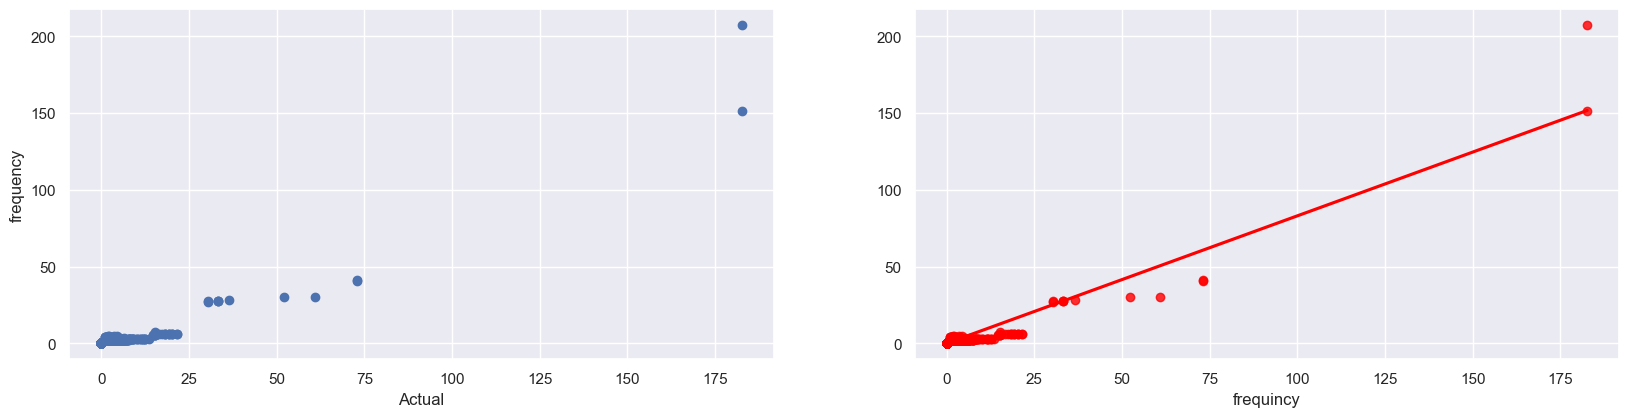

In [18]:
plt.subplot(221)
plt.scatter(ytest,y_pred);

plt.xlabel('Actual');
plt.ylabel('frequency');

plt.subplot(222)
sns.regplot(x=ytest,y=y_pred,ci=None,color ='red');

In [19]:
importance=pd.concat([pd.DataFrame(XGBRFRegressor_model.feature_names_in_,columns=["feature_names"]),
           pd.DataFrame(XGBRFRegressor_model.feature_importances_,columns=["feature_importances"])],axis=1)

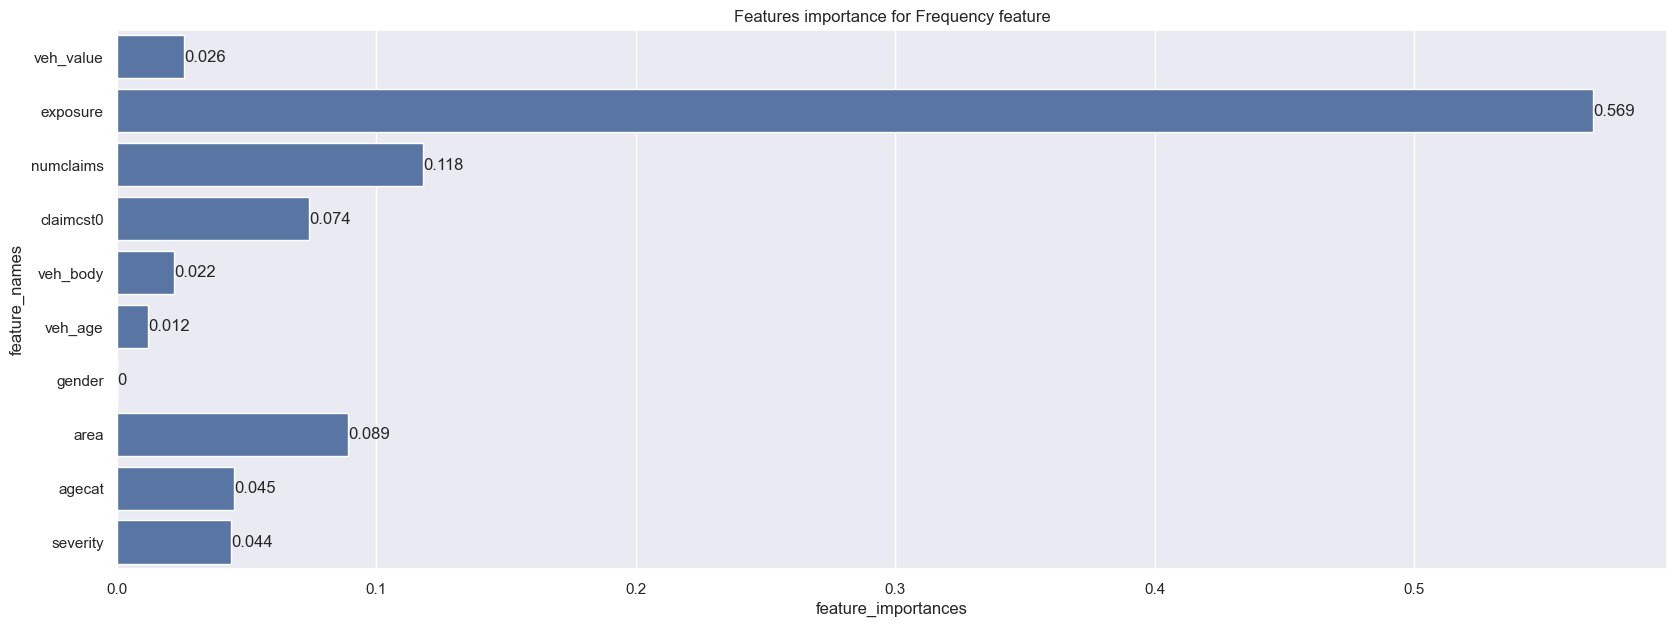

In [20]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for Frequency feature')
ax.bar_label(ax.containers[0]);

In [21]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/final_models/Frequency_final_model.pkl","wb") as f:
    pickle.dump(XGBRFRegressor_model,f)

In [24]:
import joblib
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/final_models/Frequency_final_model_joblib.joblib","wb") as f:
    pickle.dump(XGBRFRegressor_model,f)

---